<a href="https://colab.research.google.com/github/SinghAnkit1010/Artinum-Segmentation/blob/main/Artinum_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install celluloid
!pip install pytorch_lightning

# **Importing Libraries**

In [3]:
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from celluloid import Camera
from IPython.display import HTML
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

# **Data Preprocessing and Visualization**

In [4]:
image_directory = '/content/drive/MyDrive/Task02_Heart/imagesTr'
label_directory = '/content/drive/MyDrive/Task02_Heart/labelsTr'

In [5]:
image_filepath = []
label_filepath = []
for file_name in os.listdir(image_directory):
  if(file_name.startswith('la')):
    image_filepath.append(os.path.join(image_directory,file_name))
    label_filepath.append(os.path.join(label_directory,file_name))

In [6]:
sample_path = image_filepath[0]
sample_path_label = label_filepath[0]

In [7]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

In [8]:
mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [9]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [ ]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
  plt.imshow(mri[:,:,i],cmap = 'bone')
  mask_ = np.ma.masked_where(mask[:,:,i] == 0,mask[:,:,i])
  plt.imshow(mask_,alpha = 0.5)
  camera.snap()
animation = camera.animate()

In [11]:
HTML(animation.to_html5_video())

In [12]:
def normalized(full_volume):
  mu = full_volume.mean()
  std = np.std(full_volume)
  normalize = (full_volume - mu) / std
  return normalize

In [13]:
def standardized(normalized):
  standardize = (normalized - normalized.min()) / (normalized.max() - normalized.min())
  return standardize

In [14]:
preprocessed_path = 'Preprocessed'
os.makedirs(preprocessed_path)
for i in range(len(image_filepath)):
  images = nib.load(image_filepath[i])
  masks = nib.load(label_filepath[i])
  mri_data = images.get_fdata()
  label_data = masks.get_fdata().astype(np.uint8)
  # print(nib.aff2axcodes(images.affine))
  mri_data = mri_data[32:-32,32:-32]                    # don't crop along viewing axis
  label_data = label_data[32:-32,32:-32]
  normalize_data = normalized(mri_data)
  standardize_data = standardized(normalize_data)

  if(i < 17):
    x_dir = preprocessed_path + '/train/' + str(i) + '/images/'
    os.makedirs(x_dir)
    y_dir = preprocessed_path + '/train/' + str(i) + '/labels/'
    os.makedirs(y_dir)
  else:
    x_dir = preprocessed_path + '/valid/' + str(i) + '/images/'
    os.makedirs(x_dir)
    y_dir = preprocessed_path + '/valid/' + str(i) + '/labels/'
    os.makedirs(y_dir)


  for j in range(standardize_data.shape[-1]):
    Slice = standardize_data[:,:,j]
    label = label_data[:,:,j]
    np.save(os.path.join(x_dir,str(j)),Slice)
    np.save(os.path.join(y_dir,str(j)),label)


#**Creating UNet Model**

In [15]:
class ConvBlock(torch.nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()
    self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels=in_channel,out_channels=out_channel,kernel_size=3,padding=1),
                                    torch.nn.BatchNorm2d(out_channel),
                                    torch.nn.ReLU(),
                                    torch.nn.Conv2d(in_channels=out_channel,out_channels=out_channel,kernel_size=3,padding=1),
                                    torch.nn.BatchNorm2d(out_channel),
                                    torch.nn.ReLU())
  def forward(self,x):
    return self.step(x)

In [16]:
class UNet(torch.nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()
    self.conv1 = ConvBlock(in_channel,64)
    self.conv2 = ConvBlock(64,128)
    self.conv3 = ConvBlock(128,256)
    self.conv4 = ConvBlock(256,512)

    self.conv5 = ConvBlock(512,1024)

    self.deconv1 = ConvBlock(1024,512)
    self.deconv2 = ConvBlock(512,256)
    self.deconv3 = ConvBlock(256,128)
    self.deconv4 = ConvBlock(128,64)

    self.output = torch.nn.Conv2d(in_channels=64,out_channels=out_channel,kernel_size = 1)

    self.maxpool = torch.nn.MaxPool2d(2)

  def forward(self,x):
    x1 = self.conv1(x)
    x1m = self.maxpool(x1)

    x2 = self.conv2(x1m)
    x2m = self.maxpool(x2)

    x3 = self.conv3(x2m)
    x3m = self.maxpool(x3)

    x4 = self.conv4(x3m)
    x4m = self.maxpool(x4)


    encoder_output = self.conv5(x4m)


    y4 =  torch.nn.ConvTranspose2d(in_channels = 1024,out_channels = 512,kernel_size = 2,stride = 2).cuda()(encoder_output)
    y4 = torch.cat([x4,y4],dim=1)
    y4 = self.deconv1(y4)

    y3 = torch.nn.ConvTranspose2d(in_channels=512,out_channels = 256,kernel_size = 2,stride = 2).cuda()(y4)
    y3 = torch.cat([x3,y3],dim=1)
    y3 = self.deconv2(y3)

    y2 = torch.nn.ConvTranspose2d(in_channels = 256,out_channels = 128,kernel_size=2,stride = 2).cuda()(y3)
    y2 = torch.cat([x2,y2],dim=1)
    y2 = self.deconv3(y2)

    y1 = torch.nn.ConvTranspose2d(in_channels = 128,out_channels = 64,kernel_size = 2,stride = 2).cuda()(y2)
    y1 = torch.cat([x1,y1],dim=1)
    y1 = self.deconv4(y1)

    output = self.output(y1)
    return output

#**Dataset Creation**

In [17]:
class CustomMRI_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir,augment_params):
        self.data_dir = data_dir
        self.augment_params = augment_params
        self.patients = os.listdir(data_dir)
        self.file_paths = []

        for patient_mri in self.patients:
            slices_path = os.path.join(data_dir, patient_mri, 'images')
            mask_path = os.path.join(data_dir, patient_mri, 'labels')

            for slices in os.listdir(slices_path):
                x_path = os.path.join(slices_path, slices)
                y_path = os.path.join(mask_path, slices)

                self.file_paths.append((x_path, y_path))

    def augments(self,slice,mask):
      random_seed = torch.randint(0,100000,(1, )).item()
      imgaug.seed(random_seed)

      mask = SegmentationMapsOnImage(mask,mask.shape)
      slice_aug,mask_aug = self.augment_params(image = slice,segmentation_maps = mask)
      mask_aug = mask_aug.get_arr()

      return slice_aug,mask_aug

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        x_path, y_path = self.file_paths[idx]

        x_data = np.load(x_path).astype(np.float32)
        y_data = np.load(y_path)

        if self.augment_params:
          x_data,y_data = self.augments(x_data,y_data)

        return np.expand_dims(x_data,0), np.expand_dims(y_data,0)


In [18]:
seq = iaa.Sequential([iaa.Affine(scale = (0.85,1.15),rotate = (-45,45)),
                      iaa.ElasticTransformation()])

In [19]:
train_data_path = "/content/Preprocessed/train/"
custom_dataset = CustomMRI_Dataset(train_data_path,seq)

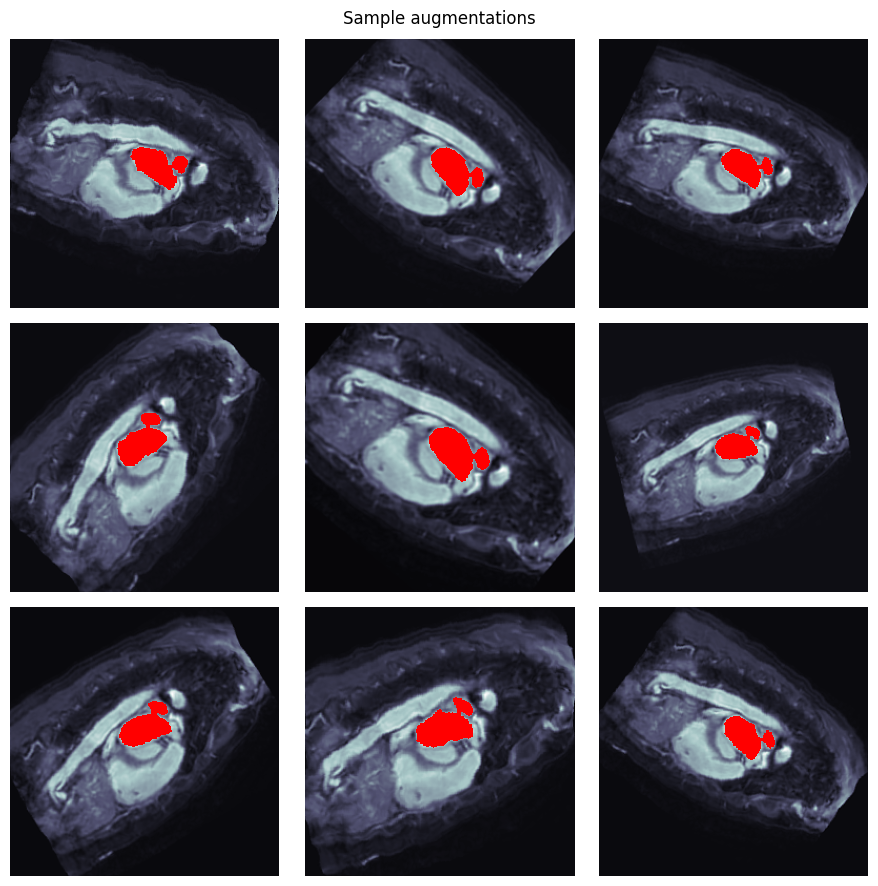

In [20]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = custom_dataset[9]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()

#**training model**

In [21]:
train_path = '/content/Preprocessed/train'
valid_path = '/content/Preprocessed/valid'

In [22]:
seq = iaa.Sequential([iaa.Affine(scale = (0.85,1.15),rotate = (-45,45)),
                      iaa.ElasticTransformation()])

In [23]:
train_dataset = CustomMRI_Dataset(train_path,seq)
valid_dataset = CustomMRI_Dataset(valid_path,None)

In [24]:
train_dataset = torch.utils.data.DataLoader(train_dataset,batch_size = 16,shuffle = True)
valid_dataset = torch.utils.data.DataLoader(valid_dataset,batch_size = 16,shuffle = False)

In [25]:
class DiceLoss(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,pred,actual):
    pred = torch.flatten(pred)
    actual = torch.flatten(actual)

    counter = (actual * pred).sum()
    numer = 2 * counter
    denum = actual.sum() + pred.sum() + 1e-8
    dice = numer / denum
    return 1-dice

In [26]:
class segmentation_model(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.model = UNet(1,1)
    self.model.cuda()
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr=1e-4)
    self.loss_function = DiceLoss()

  def forward(self,data):
    return torch.sigmoid(self.model(data))

  def training_step(self,batch,batch_idx):
    x,y = batch
    y = y.float()
    pred = self(x)
    loss = self.loss_function(pred,y)

    self.log('Train Dice',loss)
    if batch_idx % 50 == 0:
      self.log_images(x.cpu(),pred.cpu(),y.cpu(),'Train')
    return loss

  def validation_step(self,batch,batch_idx):
    x,y = batch
    y = y.float()
    pred = self(x)
    loss = self.loss_function(pred,y)

    self.log('Val Dice',loss)
    if(batch_idx % 2 == 0):
      self.log_images(x.cpu(),pred.cpu(),y.cpu(),'Val')
    return loss

  def log_images(self,x,pred,y,name):
    ped = pred > 0.5

    fig,axis = plt.subplots(1,2)

    axis[0].imshow(x[0][0],cmap = 'bone')
    y_ = np.ma.masked_where(y[0][0] == 0,y[0][0])
    axis[0].imshow(y_,alpha = 0.6)

    axis[1].imshow(x[0][0],cmap = 'bone')
    pred_ = np.ma.masked_where(pred[0][0].detach().cpu().numpy() == 0,pred[0][0].detach().cpu().numpy())
    axis[1].imshow(pred_,alpha = 0.6)

    self.logger.experiment.add_figure(name,fig,self.global_step)

  def configure_optimizers(self):
    return [self.optimizer]

In [27]:
torch.manual_seed(0)
training_model = segmentation_model()

In [28]:
checkpoint_callback = ModelCheckpoint(monitor = 'Val Dice',save_top_k=5,mode = 'min')

In [29]:
trainer = pl.Trainer(logger =TensorBoardLogger(save_dir = 'logs'),log_every_n_steps=1 ,callbacks = checkpoint_callback,max_epochs = 30)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(training_model,train_dataset,valid_dataset)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type     | Params
-------------------------------------------
0 | model         | UNet     | 28.3 M
1 | loss_function | DiceLoss | 0     
-------------------------------------------
28.3 M    Trainable params
0         Non-trainable params
28.3 M    Total params
113.025   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


# **Model Evaluation**

In [31]:
model = segmentation_model.load_from_checkpoint('/content/logs/lightning_logs/version_0/checkpoints/epoch=29-step=3630.ckpt')

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

segmentation_model(
  (model): UNet(
    (conv1): ConvBlock(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (conv2): ConvBlock(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (conv3): ConvBlock(
      (step): Sequential(
        (0): 

In [33]:
loss = 0
batch = 0
for x,y in valid_dataset:
  x = torch.tensor(x).to(device)
  y = torch.tensor(y).to(device)
  with torch.no_grad():
    pred = model(x)
  loss += model.loss_function(pred,y).cpu().numpy()
  batch +=1
total_loss = loss/batch

<ipython-input-33-3a09126c9f68>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
<ipython-input-33-3a09126c9f68>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(device)


In [34]:
dice_score = 1 - total_loss

In [35]:
print(dice_score)

0.8775690821084109


In [110]:
image_path = "/content/Preprocessed/valid/17/images/101.npy"
mask_path = "/content/Preprocessed/valid/17/labels/101.npy"

In [111]:
x_data = np.expand_dims(np.load(image_path).astype(np.float32),0)
y_data = np.expand_dims(np.load(mask_path),0)

In [112]:
with torch.no_grad():
  prediction_on_valid = model(torch.tensor(x_data).unsqueeze(0).float().to(device))[0]
  prediction_on_valid = prediction_on_valid > 0.5
final_prediction = prediction_on_valid.cpu().numpy()

Text(0.5, 1.0, 'predicted')

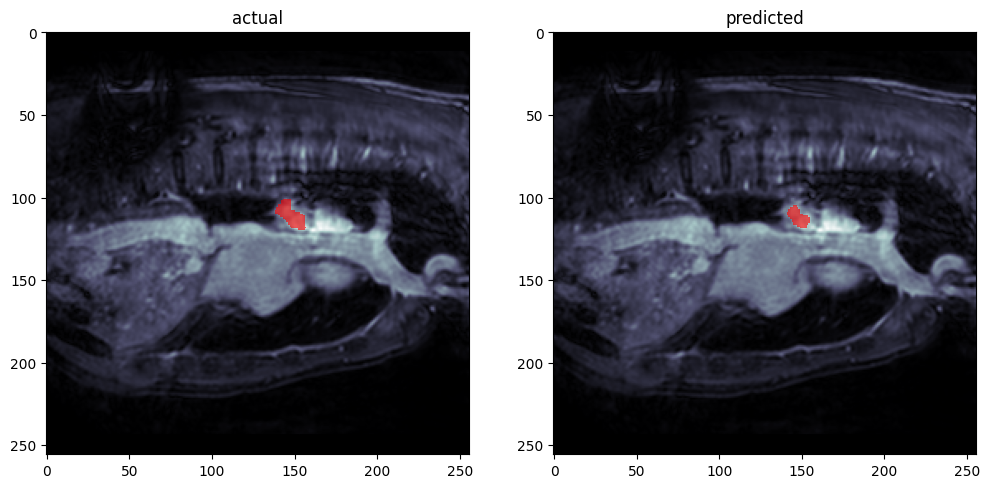

In [113]:
fig,axis = plt.subplots(1,2,figsize=(12, 6))

axis[0].imshow(x_data[0],cmap = 'bone')
y_data = np.ma.masked_where(y_data[0] == 0,y_data[0])
axis[0].imshow(y_data,alpha = 0.6,cmap = 'autumn')
axis[0].set_title('actual')

axis[1].imshow(x_data[0],cmap = 'bone')
pred_ = np.ma.masked_where(final_prediction[0] == 0,final_prediction[0])
axis[1].imshow(pred_,alpha = 0.6,cmap = 'autumn')
axis[1].set_title('predicted')

# **Evaluation on test data**


In [114]:
test_patient_path = '/content/drive/MyDrive/Task02_Heart/imagesTs/la_002.nii.gz'

In [115]:
test_patient = nib.load(test_patient_path).get_fdata()

In [116]:
test_patient.shape

(320, 320, 140)

In [117]:
test_patient = test_patient[32:-32,32:-32]
preprocessed_data = standardized(normalized(test_patient))

In [118]:
preprocessed_data.shape

(256, 256, 140)

In [119]:
preds =  []
for i in range(preprocessed_data.shape[-1]):
  curr_slice = preprocessed_data[:,:,i]
  with torch.no_grad():
    pred = model(torch.tensor(curr_slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
    pred = pred > 0.5
  preds.append(pred.cpu())

In [ ]:
fig = plt.figure()
camera = Camera(fig)
for i in range(preprocessed_data.shape[-1]):
  plt.imshow(preprocessed_data[:,:,i],cmap = 'bone')
  mask_ = np.ma.masked_where(preds[i] == 0,preds[i])
  plt.imshow(mask_,alpha = 0.4,cmap = 'autumn')
  camera.snap()
animation = camera.animate()

In [122]:
HTML(animation.to_html5_video())